# Analysis grid-wise on the predictions

This example is about analyzing how the predictions are at pixel level, trying to detect any variation along the pixels, such as close to the edges.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import context
from mlnowcasting.utils.torch_trainer import Torch_Trainer
from mlnowcasting.utils.metrics import metric_plots, events_metrics, _event_metrics
from mlnowcasting.utils.utils import any2reflectivity, binarize
from mlnowcasting.predict import predict

### Set the model and dataset

In [2]:
model_file    = 'convGRU_16_16'
dataset       = '../data/datasets/example_dataset.npy' 

Define a function to get predictions and observations

Get the predictions

In [3]:
prediction, target = predict(dataset, model_file)
prediction.shape, target.shape

=> loaded checkpoint 'convGRU_16_16.th' (trained for 300 epochs)


((10, 16, 64, 64), (10, 16, 64, 64))

## Metric analysis

Define a plotting function

In [4]:
def plot_metrics_gridwise(prediction, name, vmin=None, vmax=None):
    if vmin is None:
        vmin=np.min(prediction)
        vmax=np.max(prediction)
    first=True
    # specific for the use I gave it, change to convenience
    titles = ['+ 0 min','+ 20 min','+ 40 min','+ 60 min']
    plt.figure(figsize=(12,6))
    for i in range(4):    
        plt.subplot(1,5,i+1)
        plt.title(titles[i])
        plt.imshow(prediction[i*4], vmin=vmin, vmax=vmax, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if first:
            plt.ylabel(name)
            first = False
    plt.subplot(1,5,5)
    plt.imshow(prediction[i*4], vmin=vmin, vmax=vmax, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_visible(False)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()

In [5]:
def fill_nans(y):
    ''' replace all NaN with 0s '''
    where_are_NaNs = np.isnan(y)
    y[where_are_NaNs] = 0
    return y

Define metric reflectivity threshold in dBZ

In [6]:
th=20

Compute the metrics gridwise

In [7]:
target_binary = binarize(target,th)
prediction_binary = binarize(prediction,th)

T = target.shape[1] * target.shape[2]

combined = target_binary*2 + prediction_binary 
hits = (combined==3).sum(0)
misses = (combined==2).sum(0)
false_alarms = (combined==1).sum(0)
correct_reject = (combined==0).sum(0)

hits = fill_nans(hits)
misses = fill_nans(misses)
false_alarms = fill_nans(false_alarms)
correct_reject = fill_nans(correct_reject)

MSE = np.mean((target - prediction)**2, axis=0)
MAE = np.mean(np.abs(target - prediction), axis=0)
        
CSI = (hits/(hits+misses+false_alarms))
FAR = (false_alarms/(hits+false_alarms))
POD = (hits/(hits+misses))
C = (hits+false_alarms)*(hits+misses)/T
ETS = (hits-C)/(hits+false_alarms+misses-C)
ACC = (hits+correct_reject)/T
FBS = (hits+false_alarms)/(hits+misses)

Plot a metric

Bear in mind that for this to be representative you need to use a large dataset

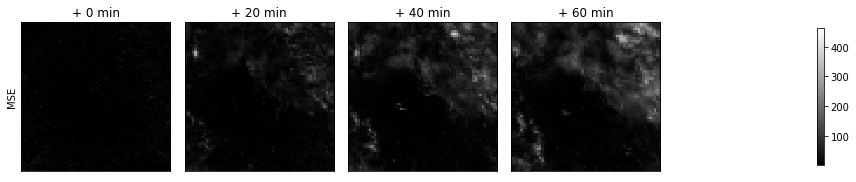

In [8]:
plot_metrics_gridwise(MSE, name='MSE')

## Contrast analysis

For the contrast analysis the following approach is used (based on https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/):

    -compute the laplacian
    -compute the variance (in this case the absolute of the standard deviation)
low variance means blur, high variance abrupt changes

In [9]:
from scipy.ndimage.filters import generic_filter, laplace

c_target = laplace(target).mean(0)
c_prediction = laplace(prediction).mean(0)

v_target = abs(generic_filter(c_target, np.std, size=3))
v_prediction = abs(generic_filter(c_prediction, np.std, size=3, mode='reflect'))

Define a plotting function

In [10]:
def plot_blur(target, prediction, vmin=None, vmax=None):

    if vmin is None:
        vmin=min(np.min(target),np.min(prediction))
        vmax=max(np.max(target),np.max(prediction))
    first=True
    titles = ['+ 0 min','+ 20 min','+ 40 min','+ 60 min']
    fig = plt.figure(figsize=(12,6))
    for i in range(4):
        plt.subplot(2,4,i+1)
        plt.imshow(target[i*4], vmin=vmin, vmax=vmax, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if first:
            plt.ylabel('Observation')
        plt.title(titles[i])    
        plt.subplot(2,4,i+4+1)
        plt.imshow(prediction[i*4], vmin=vmin, vmax=vmax, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if first:
            plt.ylabel('Prediction')
            first = False
    plt.subplot(1,5,5)
    plt.imshow(prediction[i*4], vmin=vmin, vmax=vmax, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_visible(False)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig

Plot the analysis

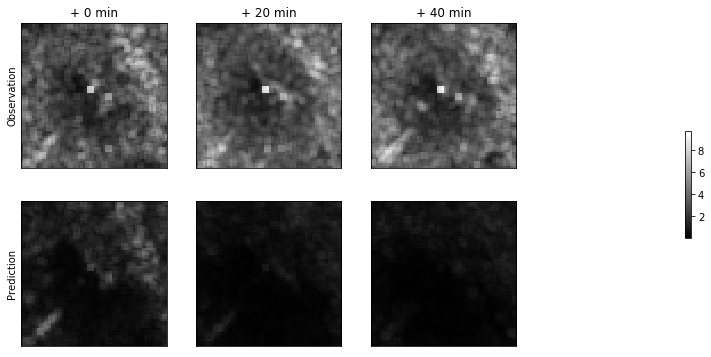

In [11]:
fig = plot_blur(v_target, v_prediction)